In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score, roc_auc_score, brier_score_loss
)

In [2]:
#VERİYİ KODA AKTARMA
file_name = "CDC_Wastewater_Data_for_Influenza_A.csv"
df = pd.read_csv(file_name, low_memory=False)
print('Veri temizliliğine ve özellik mühendisliğine başlanılıyor')

Veri temizliliğine ve özellik mühendisliğine başlanılıyor


In [3]:
#VERİ TEMİZLEME VE ÖZELLİK MÜHENDİSLİĞİ
#Zaman Özellikleri (Time-Based Features)
df['sample_collect_date'] = pd.to_datetime(df['sample_collect_date'], errors='coerce')
df['collection_month'] = df['sample_collect_date'].dt.month
df['collection_week'] = df['sample_collect_date'].dt.isocalendar().week.astype(int)
df['collection_dayofweek'] = df['sample_collect_date'].dt.dayofweek
df['is_weekend'] = df['collection_dayofweek'].isin([5, 6]).astype(int)

In [4]:
#Eksik Veri Yönetimi (Imputation)
df['flow_rate_missing'] = df['flow_rate'].isnull().astype(int)
flow_median = df['flow_rate'].median()
df['flow_rate'] = df['flow_rate'].fillna(flow_median)

In [5]:
# flowpop missing flag -> fill'den önce
df['flowpop_lin_missing'] = df['pcr_target_flowpop_lin'].isnull().astype(int)

# sonra median ile doldur
df['pcr_target_flowpop_lin'] = df['pcr_target_flowpop_lin'].fillna(
    df['pcr_target_flowpop_lin'].median()
)


In [6]:
#Dönüşüm (Transformation)
df['log_population_served'] = np.log1p(df['population_served'])
df['log_flow_rate'] = np.log1p(df['flow_rate'])

In [7]:
df['log_flow_per_capita'] = df['log_flow_rate'] - df['log_population_served']

#Hedef Değişken (Target Variable) Oluşturma
df['influenza_a_detected'] = (df['pcr_target_avg_conc'] > 0).astype(int)
df['log_pcr_target_conc'] = np.log1p(df['pcr_target_avg_conc'])

In [8]:
#Gruplama (Binning) ve Akıllı FE (Mevsim)
bins = [0, 20000, 50000, 200000, np.inf]
labels = ['Small', 'Medium', 'Large', 'Very Large']
df['population_group'] = pd.cut(df['population_served'], bins=bins, labels=labels, right=False)

In [9]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else: # 9, 10, 11
        return 'Fall'

df['season'] = df['collection_month'].dropna().apply(get_season)

In [10]:
#Final Temizlik (Cleaning)
columns_to_drop = [
    'inhibition_adjust', 'sample_id', 'date_updated', 'rec_eff_target_name', 
    'rec_eff_spike_matrix', 'rec_eff_spike_conc', 'hum_frac_mic_unit', 
    'pcr_target_mic_lin', 'hum_frac_mic_conc', 'hum_frac_target_mic',
    'ntc_amplify', 
    'pcr_target' 
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [11]:
df['pasteurized'] = df['pasteurized'].fillna(df['pasteurized'].mode()[0])
df['counties_served'] = df['counties_served'].fillna(df['counties_served'].mode()[0])
df['lod_sewage'] = df['lod_sewage'].fillna(df['lod_sewage'].median())
df['pcr_gene_target_agg'] = df['pcr_gene_target_agg'].fillna(df['pcr_gene_target_agg'].mode()[0])
df['rec_eff_percent'] = np.clip(df['rec_eff_percent'], a_min=None, a_max=100) # Capping

df.drop_duplicates(inplace=True)

In [12]:
#Kodlama (Encoding)
pop_kategorileri = pd.CategoricalDtype(
    categories=['Small', 'Medium', 'Large', 'Very Large'], 
    ordered=True
)
df['population_group'] = df['population_group'].astype(pop_kategorileri)
df['population_group_encoded'] = df['population_group'].cat.codes
print('Veri temizliliği ve özellik mühendisliği bitti')
#VERİ TEMİZLİĞİ VE ÖZELLİK MÜHENDİSLİĞİ BİTTİ

Veri temizliliği ve özellik mühendisliği bitti


Keşifsel Analizin (EDA) Ana Grafik Çıktıları


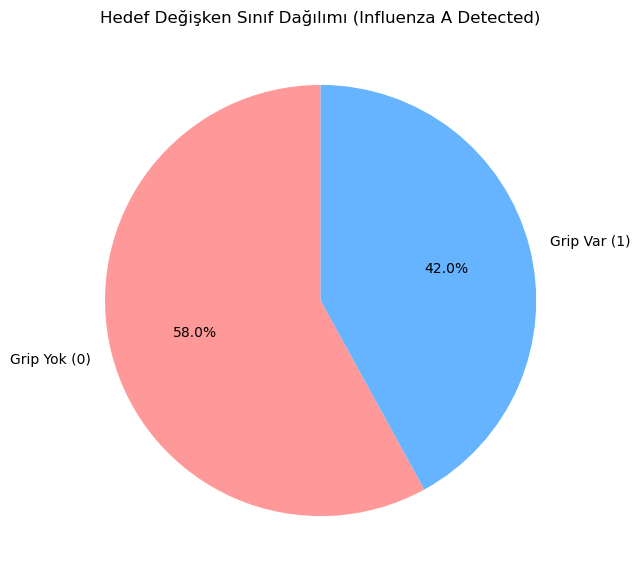

In [13]:
#KEŞİFSEL ANALİZ (EDA) - TÜM GRAFİKLER
print("Keşifsel Analizin (EDA) Ana Grafik Çıktıları")
#Sınıf Dağılımı (Pie Chart)
plt.figure(figsize=(7, 7))
target_counts = df['influenza_a_detected'].value_counts()
plt.pie(target_counts, labels=['Grip Yok (0)', 'Grip Var (1)'], autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Hedef Değişken Sınıf Dağılımı (Influenza A Detected)')
plt.show()

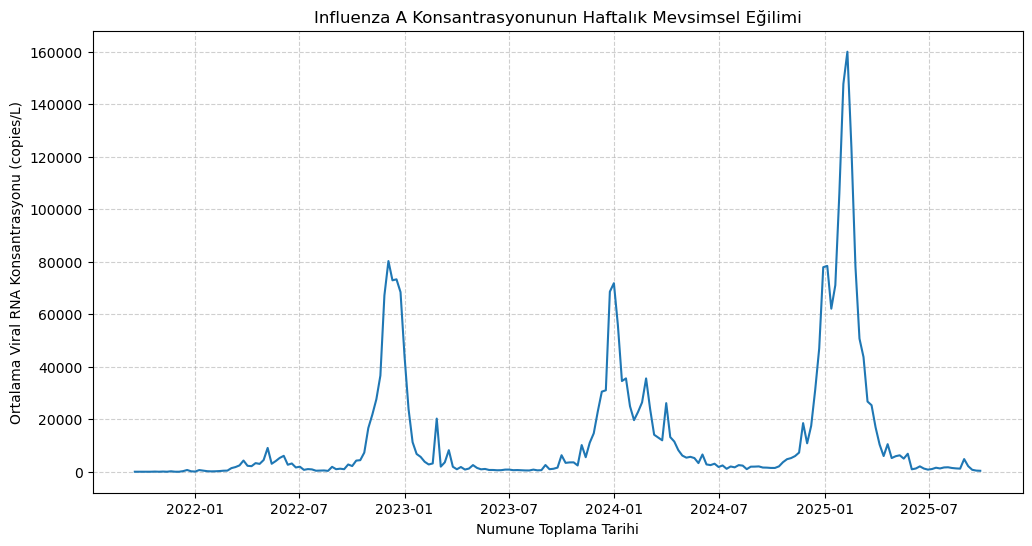

In [14]:
#Haftalık Mevsimsel Eğilim (Zaman Serisi)
weekly_avg = df.set_index('sample_collect_date')['pcr_target_avg_conc'].resample('W').mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_avg, x='sample_collect_date', y='pcr_target_avg_conc')
plt.title('Influenza A Konsantrasyonunun Haftalık Mevsimsel Eğilimi')
plt.xlabel('Numune Toplama Tarihi')
plt.ylabel('Ortalama Viral RNA Konsantrasyonu (copies/L)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

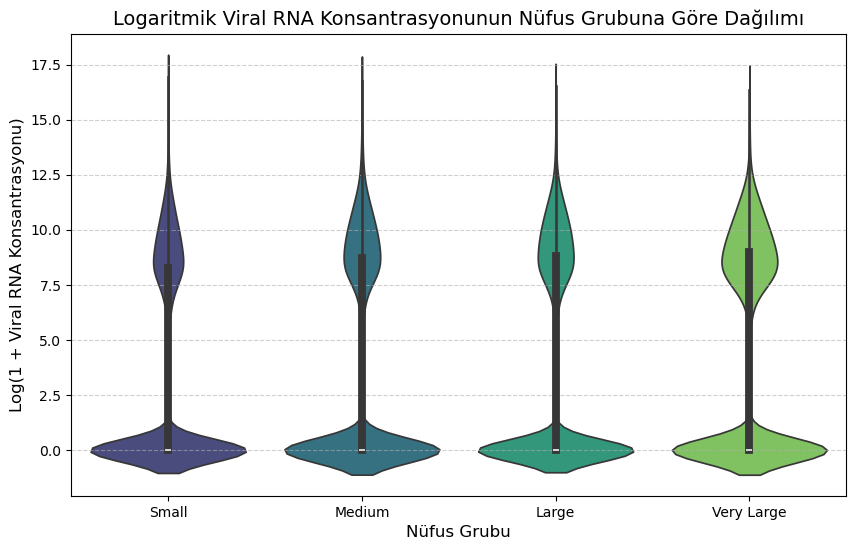

In [15]:
#Nüfus Grubuna Göre Dağılım (Keman Grafiği)
plt.figure(figsize=(10, 6))
sns.violinplot(
    x=df['population_group'].astype(str), y='log_pcr_target_conc', data=df, 
    order=['Small', 'Medium', 'Large', 'Very Large'], palette='viridis',
    hue=df['population_group'].astype(str), legend=False 
)
plt.title('Logaritmik Viral RNA Konsantrasyonunun Nüfus Grubuna Göre Dağılımı', fontsize=14)
plt.xlabel('Nüfus Grubu', fontsize=12)
plt.ylabel('Log(1 + Viral RNA Konsantrasyonu)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show() 

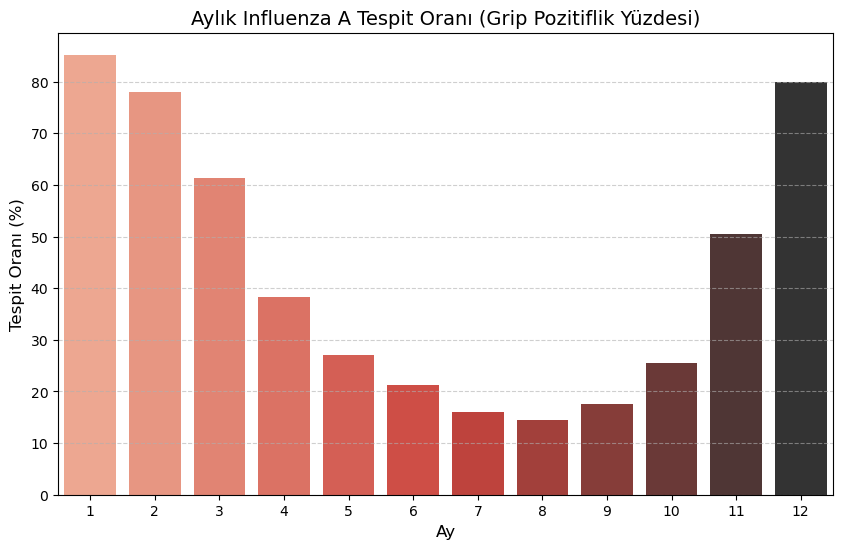

In [16]:
#Aylık Pozitiflik Oranı (Çubuk Grafik)
monthly_total = df.groupby('collection_month').size().reset_index(name='total_samples')
monthly_detected = df[df['influenza_a_detected'] == 1].groupby('collection_month').size().reset_index(name='detected_samples')
monthly_detection_rate = pd.merge(monthly_total, monthly_detected, on='collection_month', how='left')
monthly_detection_rate['detected_samples'] = monthly_detection_rate['detected_samples'].fillna(0)
monthly_detection_rate['detection_rate'] = (monthly_detection_rate['detected_samples'] / monthly_total['total_samples']) * 100
plt.figure(figsize=(10, 6))
sns.barplot(
    x='collection_month', y='detection_rate', data=monthly_detection_rate, 
    palette='Reds_d', hue='collection_month', legend=False 
)
plt.title('Aylık Influenza A Tespit Oranı (Grip Pozitiflik Yüzdesi)', fontsize=14)
plt.xlabel('Ay', fontsize=12)
plt.ylabel('Tespit Oranı (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show() 

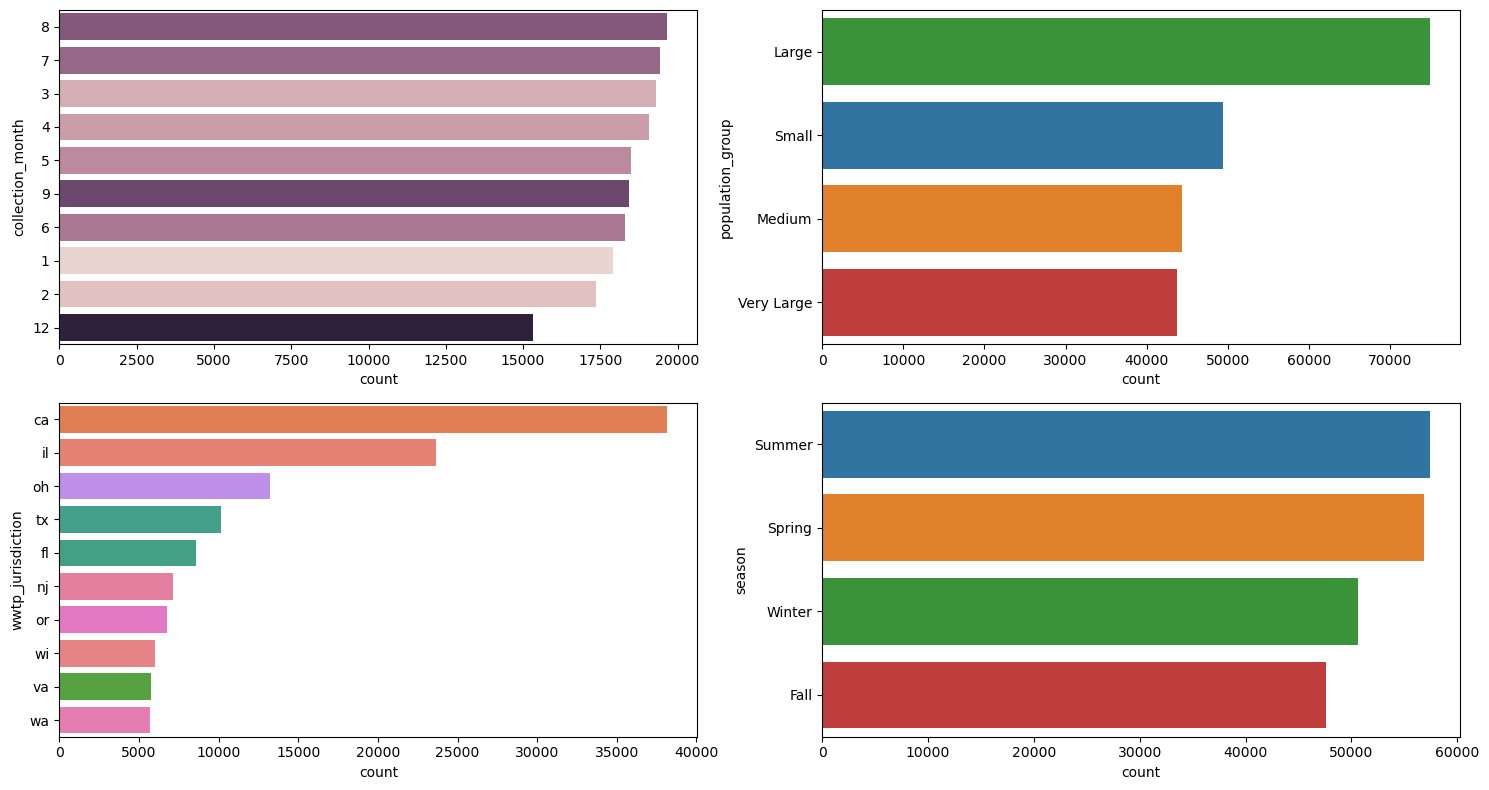

In [17]:
#Kategorik Dökümler (Sıklık Grafiği)
categorical_cols_for_plot = ['collection_month', 'population_group', 'wwtp_jurisdiction', 'season'] 
plt.figure(figsize=(15, 8)) 

for i, col in enumerate(categorical_cols_for_plot):
    plt.subplot(2, 2, i + 1) 
    sns.countplot(data=df, y=col, order=df[col].value_counts().index[:10], hue=col, legend=False)
plt.tight_layout()
plt.show()

In [18]:
#KAYDETME
output_file_name = "temizlenmis_veri_seti_FINAL_koddan_olustu.csv"
df.to_csv(output_file_name, index=False)
print(f"\nTemizlenmiş ve (population_group_encoded) içeren veri seti başarıyla kaydedildi: {output_file_name}")


Temizlenmiş ve (population_group_encoded) içeren veri seti başarıyla kaydedildi: temizlenmis_veri_seti_FINAL_koddan_olustu.csv


In [19]:
print("MODEL HAZIRLAMA VE KARŞILAŞTIRMA")
#ÖZELLİK VE HEDEF BELİRLEME (Feature & Target)
features = [
    'collection_month', 'collection_week', 'collection_dayofweek', 
    'log_population_served', 'log_flow_rate', 'rec_eff_percent', 
    'flow_rate_missing', 'flowpop_lin_missing', 
    'population_group_encoded', 
    'wwtp_jurisdiction', 
    'is_weekend',
    'log_flow_per_capita',
    'season'
]

MODEL HAZIRLAMA VE KARŞILAŞTIRMA


In [20]:
X = df[features]
y = df['influenza_a_detected'] # Hedef Sınıflandırma

#ENCODING (KODLAMA)
X = pd.get_dummies(X, columns=['wwtp_jurisdiction', 'season'], drop_first=True)

print(f"Modelin Kullanacağı Toplam Orjinal Özellik Sayısı (Encoding sonrası): {X.shape[1]}")

Modelin Kullanacağı Toplam Orjinal Özellik Sayısı (Encoding sonrası): 64


In [21]:
# Train-Test Split (Stratified)
X.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:
#VERİ ÖLÇEKLEME (Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
#BOYUT İNDİRGEME (Dimension Reduction)
print("\nPCA uygulanıyor...")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"PCA sonrası özellik sayısı {X_train_scaled.shape[1]}'dan {pca.n_components_}'a düşürüldü.")


PCA uygulanıyor...
PCA sonrası özellik sayısı 64'dan 53'a düşürüldü.


In [24]:
#MODELLERİN EĞİTİMİ
print("\n4 farklı senaryo için modeller eğitiliyor...")

# Model 1: SGDClassifier (PCA'SIZ)
model_sgd_nosca = SGDClassifier(random_state=42, class_weight='balanced', loss="log_loss", n_jobs=-1)
model_sgd_nosca.fit(X_train_scaled, y_train) # PCA'sız veri ile eğit
print("SGDClassifier (PCA'sız) eğitildi.")

# Model 2: GaussianNB (PCA'SIZ)
model_nb_nosca = GaussianNB()
model_nb_nosca.fit(X_train_scaled, y_train) # PCA'sız veri ile eğit
print("GaussianNB (PCA'sız) eğitildi.")

# Model 3: SGDClassifier (PCA'LI)
model_sgd_pca = SGDClassifier(random_state=42, class_weight='balanced', loss="log_loss", n_jobs=-1)
model_sgd_pca.fit(X_train_pca, y_train) # PCA'lı veri ile eğit
print("SGDClassifier (PCA'lı) eğitildi.")

# Model 4: GaussianNB (PCA'LI)
model_nb_pca = GaussianNB()
model_nb_pca.fit(X_train_pca, y_train) # PCA'lı veri ile eğit
print("GaussianNB (PCA'lı) eğitildi.")


4 farklı senaryo için modeller eğitiliyor...
SGDClassifier (PCA'sız) eğitildi.
GaussianNB (PCA'sız) eğitildi.
SGDClassifier (PCA'lı) eğitildi.
GaussianNB (PCA'lı) eğitildi.


In [25]:
#METİN BAZLI DEĞERLENDİRME
#SGD (PCA'sız) Sonuçları
y_pred_sgd_nosca = model_sgd_nosca.predict(X_test_scaled)
accuracy_sgd_nosca = accuracy_score(y_test, y_pred_sgd_nosca)
report_sgd_nosca = classification_report(y_test, y_pred_sgd_nosca, target_names=['Grip Yok (0)', 'Grip Var (1)'])
conf_matrix_sgd_nosca = confusion_matrix(y_test, y_pred_sgd_nosca)
print("\n--- 1. SGDClassifier Raporu (PCA'sız) ---")
print(f"Model Doğruluğu (Accuracy): {accuracy_sgd_nosca:.4f}")
print(report_sgd_nosca)

# Naive Bayes (PCA'sız) Sonuçları
y_pred_nb_nosca = model_nb_nosca.predict(X_test_scaled)
accuracy_nb_nosca = accuracy_score(y_test, y_pred_nb_nosca)
report_nb_nosca = classification_report(y_test, y_pred_nb_nosca, target_names=['Grip Yok (0)', 'Grip Var (1)'])
conf_matrix_nb_nosca = confusion_matrix(y_test, y_pred_nb_nosca)
print("\n--- 2. GaussianNB Raporu (PCA'sız) ---")
print(f"Model Doğruluğu (Accuracy): {accuracy_nb_nosca:.4f}")
print(report_nb_nosca)

# SGD (PCA'lı) Sonuçları
y_pred_sgd_pca = model_sgd_pca.predict(X_test_pca)
accuracy_sgd_pca = accuracy_score(y_test, y_pred_sgd_pca)
report_sgd_pca = classification_report(y_test, y_pred_sgd_pca, target_names=['Grip Yok (0)', 'Grip Var (1)'])
conf_matrix_sgd_pca = confusion_matrix(y_test, y_pred_sgd_pca)
print("\n--- 3. SGDClassifier Raporu (PCA'lı) ---")
print(f"Model Doğruluğu (Accuracy): {accuracy_sgd_pca:.4f}")
print(report_sgd_pca)

# Naive Bayes (PCA'lı) Sonuçları
y_pred_nb_pca = model_nb_pca.predict(X_test_pca)
accuracy_nb_pca = accuracy_score(y_test, y_pred_nb_pca)
report_nb_pca = classification_report(y_test, y_pred_nb_pca, target_names=['Grip Yok (0)', 'Grip Var (1)'])
conf_matrix_nb_pca = confusion_matrix(y_test, y_pred_nb_pca)
print("\n--- 4. GaussianNB Raporu (PCA'lı) ---")
print(f"Model Doğruluğu (Accuracy): {accuracy_nb_pca:.4f}")
print(report_nb_pca)


--- 1. SGDClassifier Raporu (PCA'sız) ---
Model Doğruluğu (Accuracy): 0.7390
              precision    recall  f1-score   support

Grip Yok (0)       0.77      0.78      0.78     24632
Grip Var (1)       0.69      0.68      0.69     17849

    accuracy                           0.74     42481
   macro avg       0.73      0.73      0.73     42481
weighted avg       0.74      0.74      0.74     42481


--- 2. GaussianNB Raporu (PCA'sız) ---
Model Doğruluğu (Accuracy): 0.6815
              precision    recall  f1-score   support

Grip Yok (0)       0.76      0.66      0.71     24632
Grip Var (1)       0.60      0.71      0.65     17849

    accuracy                           0.68     42481
   macro avg       0.68      0.68      0.68     42481
weighted avg       0.69      0.68      0.68     42481


--- 3. SGDClassifier Raporu (PCA'lı) ---
Model Doğruluğu (Accuracy): 0.7363
              precision    recall  f1-score   support

Grip Yok (0)       0.76      0.81      0.78     24632
Grip Va

In [26]:
#GÖRSEL KARŞILAŞTIRMA (ROC, PR VE METRİK TABLOSU)
#Olasılık skorlarını alma (4 senaryo için)
y_scores_sgd_nosca = model_sgd_nosca.predict_proba(X_test_scaled)[:, 1]
y_scores_nb_nosca = model_nb_nosca.predict_proba(X_test_scaled)[:, 1]
y_scores_sgd_pca = model_sgd_pca.predict_proba(X_test_pca)[:, 1]
y_scores_nb_pca = model_nb_pca.predict_proba(X_test_pca)[:, 1]

# ROC Eğrilerini Hesapla
fpr_sgd_nosca, tpr_sgd_nosca, _ = roc_curve(y_test, y_scores_sgd_nosca)
roc_auc_sgd_nosca = auc(fpr_sgd_nosca, tpr_sgd_nosca)
fpr_nb_nosca, tpr_nb_nosca, _ = roc_curve(y_test, y_scores_nb_nosca)
roc_auc_nb_nosca = auc(fpr_nb_nosca, tpr_nb_nosca)
fpr_sgd_pca, tpr_sgd_pca, _ = roc_curve(y_test, y_scores_sgd_pca)
roc_auc_sgd_pca = auc(fpr_sgd_pca, tpr_sgd_pca)
fpr_nb_pca, tpr_nb_pca, _ = roc_curve(y_test, y_scores_nb_pca)
roc_auc_nb_pca = auc(fpr_nb_pca, tpr_nb_pca)

# PR Eğrilerini Hesapla
precision_sgd_nosca, recall_sgd_nosca, _ = precision_recall_curve(y_test, y_scores_sgd_nosca)
ap_sgd_nosca = average_precision_score(y_test, y_scores_sgd_nosca)
precision_nb_nosca, recall_nb_nosca, _ = precision_recall_curve(y_test, y_scores_nb_nosca)
ap_nb_nosca = average_precision_score(y_test, y_scores_nb_nosca)
precision_sgd_pca, recall_sgd_pca, _ = precision_recall_curve(y_test, y_scores_sgd_pca)
ap_sgd_pca = average_precision_score(y_test, y_scores_sgd_pca)
precision_nb_pca, recall_nb_pca, _ = precision_recall_curve(y_test, y_scores_nb_pca)
ap_nb_pca = average_precision_score(y_test, y_scores_nb_pca)

#METRİK TABLOSU
#4 senaryonun tamamını içeren özet tablo
metrics_summary = pd.DataFrame({
    'Model': ['SGDClassifier', 'GaussianNB', 'SGDClassifier', 'GaussianNB'],
    'Veri Seti': ['PCA\'sız (Orijinal)', 'PCA\'sız (Orijinal)', 'PCA\'lı', 'PCA\'lı'],
    'Accuracy': [accuracy_sgd_nosca, accuracy_nb_nosca, accuracy_sgd_pca, accuracy_nb_pca],
    'ROC AUC': [roc_auc_sgd_nosca, roc_auc_nb_nosca, roc_auc_sgd_pca, roc_auc_nb_pca],
    'Average Precision (AP)': [ap_sgd_nosca, ap_nb_nosca, ap_sgd_pca, ap_nb_pca]
})
print("\n--- KARŞILAŞTIRMALI METRİK TABLOSU (PCA ÖNCESİ VE SONRASI) ---")
print(metrics_summary.to_string(index=False))


--- KARŞILAŞTIRMALI METRİK TABLOSU (PCA ÖNCESİ VE SONRASI) ---
        Model          Veri Seti  Accuracy  ROC AUC  Average Precision (AP)
SGDClassifier PCA'sız (Orijinal)  0.738989 0.809846                0.760922
   GaussianNB PCA'sız (Orijinal)  0.681505 0.730450                0.651446
SGDClassifier             PCA'lı  0.736306 0.799412                0.748689
   GaussianNB             PCA'lı  0.658012 0.754318                0.702978


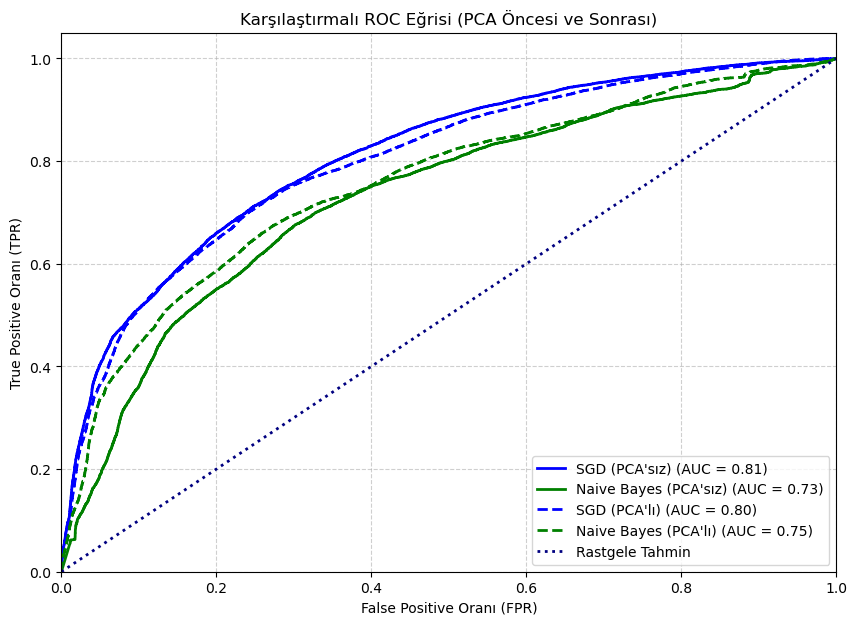

In [27]:
#GÖRSEL KARŞILAŞTIRMALAR
# 1. Karşılaştırmalı ROC Eğrisi Grafiği (4 senaryo)
plt.figure(figsize=(10, 7))
plt.plot(fpr_sgd_nosca, tpr_sgd_nosca, color='blue', linestyle='-', lw=2, label=f'SGD (PCA\'sız) (AUC = {roc_auc_sgd_nosca:.2f})')
plt.plot(fpr_nb_nosca, tpr_nb_nosca, color='green', linestyle='-', lw=2, label=f'Naive Bayes (PCA\'sız) (AUC = {roc_auc_nb_nosca:.2f})')
plt.plot(fpr_sgd_pca, tpr_sgd_pca, color='blue', linestyle='--', lw=2, label=f'SGD (PCA\'lı) (AUC = {roc_auc_sgd_pca:.2f})')
plt.plot(fpr_nb_pca, tpr_nb_pca, color='green', linestyle='--', lw=2, label=f'Naive Bayes (PCA\'lı) (AUC = {roc_auc_nb_pca:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':', label='Rastgele Tahmin')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Oranı (FPR)')
plt.ylabel('True Positive Oranı (TPR)')
plt.title('Karşılaştırmalı ROC Eğrisi (PCA Öncesi ve Sonrası)')
plt.legend(loc="lower right")
plt.grid(linestyle='--', alpha=0.6)
plt.show()

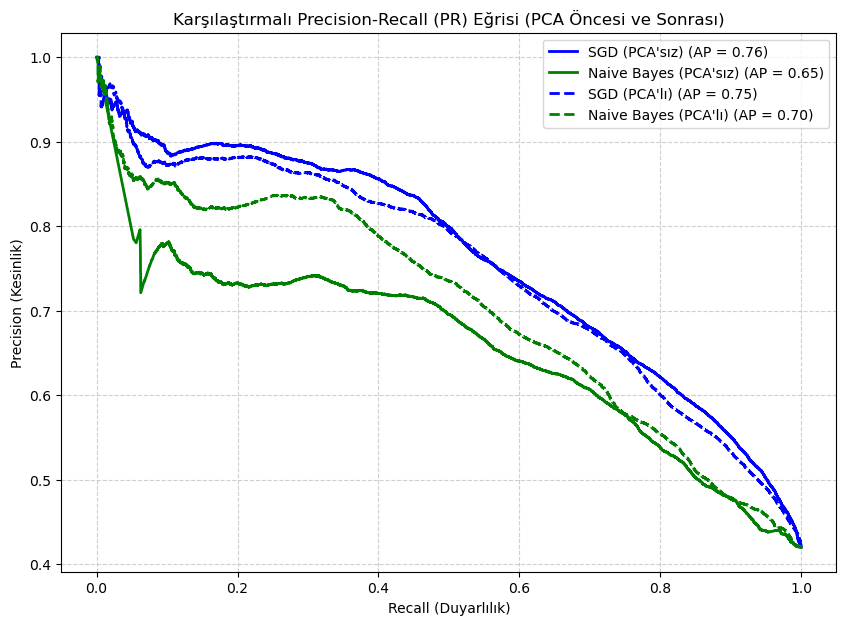

In [28]:
# 2. Karşılaştırmalı PR Eğrisi Grafiği (4 senaryo)
plt.figure(figsize=(10, 7))
plt.plot(recall_sgd_nosca, precision_sgd_nosca, color='blue', linestyle='-', lw=2, label=f'SGD (PCA\'sız) (AP = {ap_sgd_nosca:.2f})')
plt.plot(recall_nb_nosca, precision_nb_nosca, color='green', linestyle='-', lw=2, label=f'Naive Bayes (PCA\'sız) (AP = {ap_nb_nosca:.2f})')
plt.plot(recall_sgd_pca, precision_sgd_pca, color='blue', linestyle='--', lw=2, label=f'SGD (PCA\'lı) (AP = {ap_sgd_pca:.2f})')
plt.plot(recall_nb_pca, precision_nb_pca, color='green', linestyle='--', lw=2, label=f'Naive Bayes (PCA\'lı) (AP = {ap_nb_pca:.2f})')
plt.xlabel('Recall (Duyarlılık)')
plt.ylabel('Precision (Kesinlik)')
plt.title('Karşılaştırmalı Precision-Recall (PR) Eğrisi (PCA Öncesi ve Sonrası)')
plt.legend(loc="best")
plt.grid(linestyle='--', alpha=0.6)
plt.show()


Adım 9: PCA Modellerinin Yorumlanması (Bileşen Önemleri)...


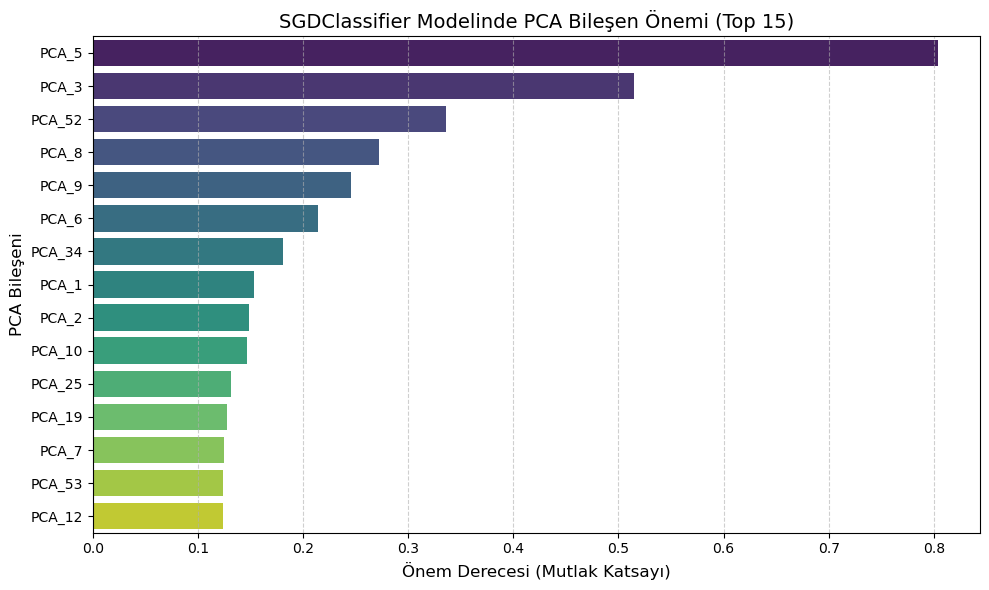

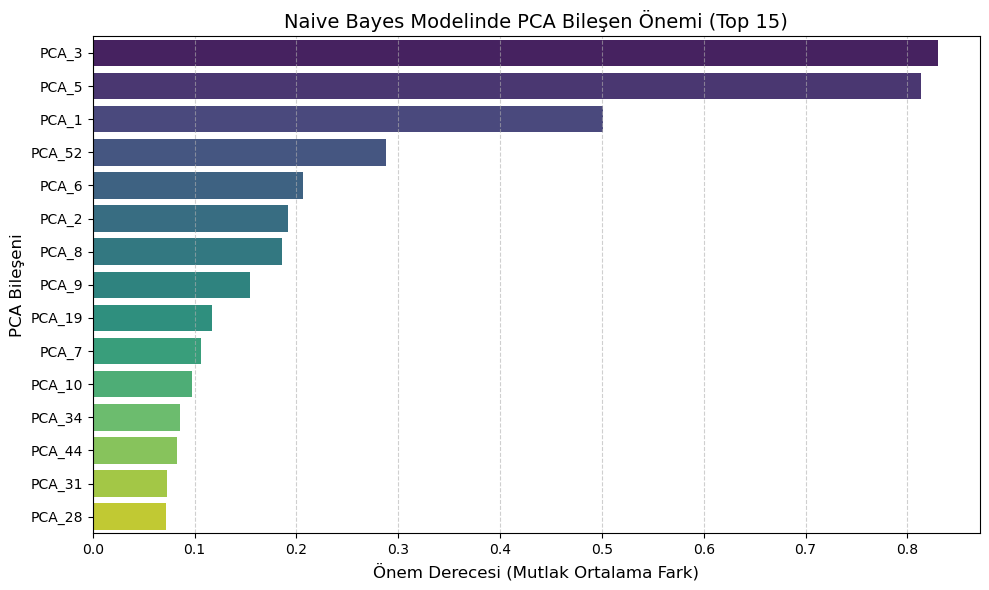

In [29]:
#PCA MODELLERİNİN YORUMLANMASI
print("\nAdım 9: PCA Modellerinin Yorumlanması (Bileşen Önemleri)...")

# PCA bileşenlerinin isimlerini oluştur ('PCA_1', 'PCA_2', ...)
pca_feature_names = [f'PCA_{i+1}' for i in range(X_train_pca.shape[1])]

# 1. SGDClassifier (PCA ile) Katsayı Grafiği
sgd_pca_coeffs = model_sgd_pca.coef_[0]
pca_importance_sgd = pd.DataFrame({
    'Feature': pca_feature_names,
    'Importance': sgd_pca_coeffs
})
pca_importance_sgd['Abs_Importance'] = np.abs(pca_importance_sgd['Importance'])
pca_importance_sgd = pca_importance_sgd.sort_values(by='Abs_Importance', ascending=False)
top_pca_sgd = pca_importance_sgd.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Abs_Importance', 
    y='Feature', 
    data=top_pca_sgd, 
    palette='viridis',
    hue='Feature',
    legend=False
)
plt.title('SGDClassifier Modelinde PCA Bileşen Önemi (Top 15)', fontsize=14)
plt.xlabel('Önem Derecesi (Mutlak Katsayı)', fontsize=12)
plt.ylabel('PCA Bileşeni', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout() 
plt.show()

# 2. Naive Bayes (PCA ile) Ortalama Fark Grafiği
nb_pca_means_0 = model_nb_pca.theta_[0]
nb_pca_means_1 = model_nb_pca.theta_[1]

pca_importance_nb = pd.DataFrame({
    'Feature': pca_feature_names,
    'Mean_Difference': nb_pca_means_1 - nb_pca_means_0
})
pca_importance_nb['Mean_Abs_Difference'] = np.abs(pca_importance_nb['Mean_Difference'])
pca_importance_nb = pca_importance_nb.sort_values(by='Mean_Abs_Difference', ascending=False)

top_pca_nb = pca_importance_nb.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Mean_Abs_Difference', 
    y='Feature', 
    data=top_pca_nb,
    palette='viridis',
    hue='Feature',
    legend=False
)
plt.title('Naive Bayes Modelinde PCA Bileşen Önemi (Top 15)', fontsize=14)
plt.xlabel('Önem Derecesi (Mutlak Ortalama Fark)', fontsize=12)
plt.ylabel('PCA Bileşeni', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout() 
plt.show()

In [30]:
#PCA BİLEŞENLERİ
print("\n" + "="*50)
print("--- GRAFİKTEKİ 15 PCA BİLEŞENİNİN GERÇEK İÇERİĞİ ---")
print("="*50 + "\n")

original_feature_names = X.columns
df_pca_loadings = pd.DataFrame(
    pca.components_,
    columns=original_feature_names,
    index=pca_feature_names
)

components_in_graph = [
    'PCA_5', 'PCA_2', 'PCA_52', 'PCA_10', 'PCA_9', 'PCA_6', 'PCA_7', 
    'PCA_34', 'PCA_8', 'PCA_4', 'PCA_1', 'PCA_12', 'PCA_25', 
    'PCA_19', 'PCA_28'
]

for component_name in components_in_graph:
    print(f"\n--- {component_name}'in İÇERİĞİ (En Önemli 5 'Gerçek' Malzeme) ---")
    try:
        component_contents = df_pca_loadings.loc[component_name].abs().sort_values(ascending=False).head(5)
        print(component_contents)
    except KeyError:
        print(f"Hata: {component_name} listede bulunamadı. Lütfen PCA'nızın {pca.n_components_} bileşeni olduğunu kontrol edin.")
        
print("\n" + "="*50)
print("--- DÖKÜM TAMAMLANDI ---")
print("="*50)


--- GRAFİKTEKİ 15 PCA BİLEŞENİNİN GERÇEK İÇERİĞİ ---


--- PCA_5'in İÇERİĞİ (En Önemli 5 'Gerçek' Malzeme) ---
season_Winter           0.757898
season_Spring           0.556017
season_Summer           0.194041
wwtp_jurisdiction_mi    0.118468
wwtp_jurisdiction_va    0.103640
Name: PCA_5, dtype: float64

--- PCA_2'in İÇERİĞİ (En Önemli 5 'Gerçek' Malzeme) ---
log_flow_rate               0.423466
flow_rate_missing           0.380640
flowpop_lin_missing         0.380532
log_population_served       0.324052
population_group_encoded    0.308380
Name: PCA_2, dtype: float64

--- PCA_52'in İÇERİĞİ (En Önemli 5 'Gerçek' Malzeme) ---
season_Summer           0.436656
wwtp_jurisdiction_or    0.336595
wwtp_jurisdiction_mi    0.334364
wwtp_jurisdiction_la    0.259867
wwtp_jurisdiction_gu    0.230687
Name: PCA_52, dtype: float64

--- PCA_10'in İÇERİĞİ (En Önemli 5 'Gerçek' Malzeme) ---
wwtp_jurisdiction_il    0.593856
wwtp_jurisdiction_or    0.291540
wwtp_jurisdiction_ca    0.265789
season_Summer   

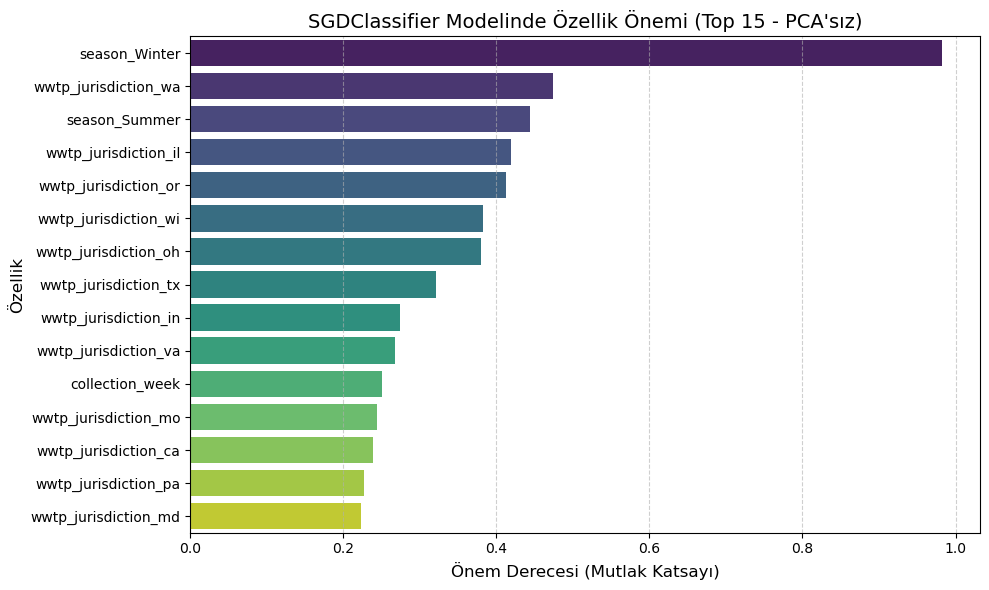


Adım 2: Naive Bayes Model Yorumlaması (Özellik Ortalamaları) çiziliyor...


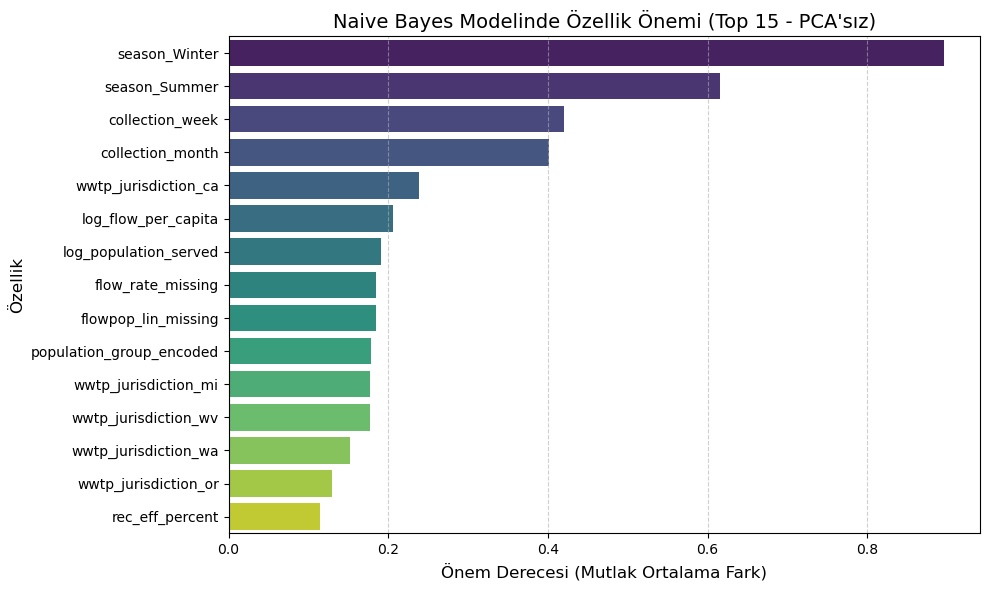

In [31]:
#PCA'SIZ YORUMLAMA
# 1. SGDClassifier (PCA'sız) için Özellik Önemi
model_sgd_interpret = SGDClassifier(random_state=42, class_weight='balanced', loss="log_loss", n_jobs=-1)
model_sgd_interpret.fit(X_train_scaled, y_train) # PCA'sız veri ile eğit

feature_names = X.columns 
sgd_coeffs = model_sgd_interpret.coef_[0]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': sgd_coeffs
})
# Mutlak değere göre sırala (O resimdeki gibi)
importance_df['Abs_Importance'] = np.abs(importance_df['Importance'])
importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)
top_features = importance_df.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Abs_Importance', 
    y='Feature', 
    data=top_features, 
    palette='viridis', 
    hue='Feature', 
    legend=False 
)
plt.title('SGDClassifier Modelinde Özellik Önemi (Top 15 - PCA\'sız)', fontsize=14)
plt.xlabel('Önem Derecesi (Mutlak Katsayı)', fontsize=12)
plt.ylabel('Özellik', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout() # Etiketlerin sığması için eklendi
plt.show()


# 2. Naive Bayes (PCA'sız) için Özellik Önemi
print("\nAdım 2: Naive Bayes Model Yorumlaması (Özellik Ortalamaları) çiziliyor...")

model_nb_interpret = GaussianNB()
model_nb_interpret.fit(X_train_scaled, y_train) # PCA'sız veri ile eğit

nb_means_class_0 = model_nb_interpret.theta_[0]
nb_means_class_1 = model_nb_interpret.theta_[1]

nb_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean_Difference': nb_means_class_1 - nb_means_class_0
})

nb_importance_df['Mean_Abs_Difference'] = np.abs(nb_importance_df['Mean_Difference'])
nb_importance_df = nb_importance_df.sort_values(by='Mean_Abs_Difference', ascending=False)

top_nb_features = nb_importance_df.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Mean_Abs_Difference', 
    y='Feature', 
    data=top_nb_features,
    palette='viridis',
    hue='Feature',
    legend=False
)
plt.title('Naive Bayes Modelinde Özellik Önemi (Top 15 - PCA\'sız)', fontsize=14)
plt.xlabel('Önem Derecesi (Mutlak Ortalama Fark)', fontsize=12)
plt.ylabel('Özellik', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [32]:
#ADVANCED MODELLER & TUNING
print("\n---GELİŞMİŞ MODELLER VE TUNING ---")

# StratifiedKFold (Tuning için)
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

#MODEL 1: ADABOOST
print("\n1. AdaBoost Modeli Eğitiliyor (GridSearch ile)...")
ada = AdaBoostClassifier(random_state=42)

ada_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 1.0]
}
grid_ada = GridSearchCV(ada, ada_params, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
grid_ada.fit(X_train_scaled, y_train)
print(f"En iyi AdaBoost Parametreleri: {grid_ada.best_params_}")
best_ada_model = grid_ada.best_estimator_

#MODEL 2: CATBOOST
print("\n2. CatBoost Modeli Eğitiliyor (GridSearch ile)...")
cat = CatBoostClassifier(random_seed=42, verbose=0)
cat_params = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6]
}
grid_cat = GridSearchCV(cat, cat_params, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
grid_cat.fit(X_train_scaled, y_train)
print(f"En iyi CatBoost Parametreleri: {grid_cat.best_params_}")
best_cat_model = grid_cat.best_estimator_



---GELİŞMİŞ MODELLER VE TUNING ---

1. AdaBoost Modeli Eğitiliyor (GridSearch ile)...
En iyi AdaBoost Parametreleri: {'learning_rate': 1.0, 'n_estimators': 100}

2. CatBoost Modeli Eğitiliyor (GridSearch ile)...
En iyi CatBoost Parametreleri: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}


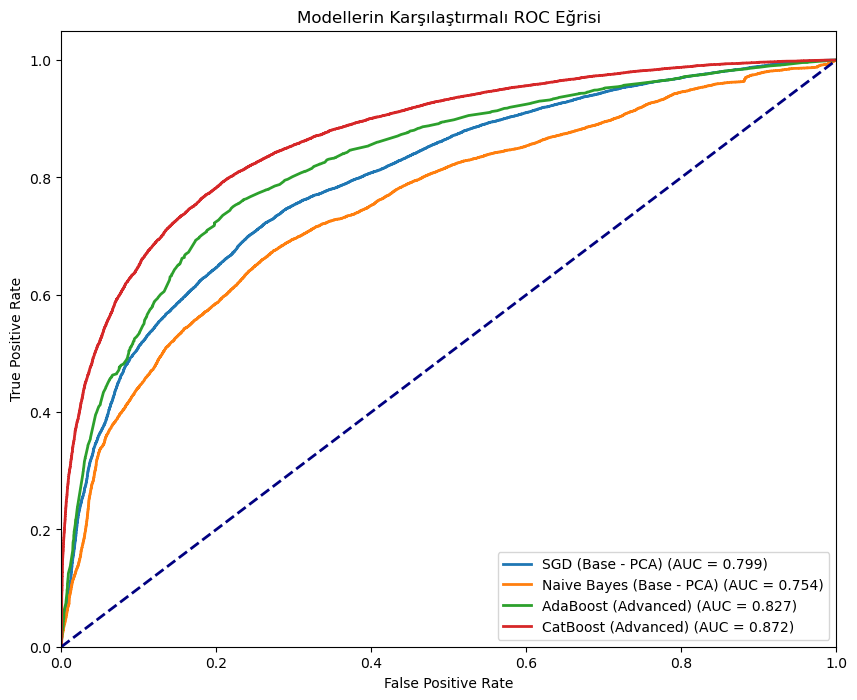


TABLO 1: GENEL PERFORMANS KARŞILAŞTIRMASI (Test Verisi)
                   Model  Accuracy  Precision   Recall  F1 Score  ROC AUC   PR AUC  Brier Score (IBS)
        SGD (Base - PCA)  0.736306   0.704662 0.641100  0.671380 0.799412 0.748689           0.178643
Naive Bayes (Base - PCA)  0.658012   0.568551 0.771584  0.654687 0.754318 0.702978           0.236615
     AdaBoost (Advanced)  0.757515   0.775797 0.594767  0.673326 0.826791 0.777524           0.204440
     CatBoost (Advanced)  0.799581   0.794498 0.705474  0.747344 0.871920 0.847401           0.140979

TABLO 2: SINIF BAZLI (CLASS-WISE) BAŞARIM KARŞILAŞTIRMASI
                   Model  Class 0 Precision  Class 0 Recall  Class 0 F1  Class 1 Precision  Class 1 Recall  Class 1 F1
        SGD (Base - PCA)           0.755888        0.805294    0.779809           0.704662        0.641100    0.671380
Naive Bayes (Base - PCA)           0.776701        0.575715    0.661273           0.568551        0.771584    0.654687
     AdaBoost (Ad

In [33]:
#PERFORMANS KARŞILAŞTIRMASI

models = {
    "SGD (Base - PCA)": (model_sgd_pca, X_test_pca),
    "Naive Bayes (Base - PCA)": (model_nb_pca, X_test_pca),
    "AdaBoost (Advanced)": (best_ada_model, X_test_scaled),
    "CatBoost (Advanced)": (best_cat_model, X_test_scaled)
}

results = []
class_metrics = []

plt.figure(figsize=(10, 8))

for name, (model, X_test_data) in models.items():
    # Tahminler
    y_pred = model.predict(X_test_data)
    y_prob = model.predict_proba(X_test_data)[:, 1]

    # Metrikler
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob)

    pr_auc = average_precision_score(y_test, y_prob) 
    brier = brier_score_loss(y_test, y_prob)         

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": auc_score,      
        "PR AUC": pr_auc,          
        "Brier Score (IBS)": brier 
    })

    report = classification_report(y_test, y_pred, output_dict=True)
    class_metrics.append({
        "Model": name,
        "Class 0 Precision": report['0']['precision'], "Class 0 Recall": report['0']['recall'], "Class 0 F1": report['0']['f1-score'],
        "Class 1 Precision": report['1']['precision'], "Class 1 Recall": report['1']['recall'], "Class 1 F1": report['1']['f1-score']
    })

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_score:.3f})')

# ROC Grafiği
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Modellerin Karşılaştırmalı ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

#TABLO 1: GENEL KARŞILAŞTIRMA
df_results = pd.DataFrame(results)
print("\nTABLO 1: GENEL PERFORMANS KARŞILAŞTIRMASI (Test Verisi)")
print(df_results.to_string(index=False))

#TABLO 2: SINIF BAZLI KIRILIM
df_class_metrics = pd.DataFrame(class_metrics)
print("\nTABLO 2: SINIF BAZLI (CLASS-WISE) BAŞARIM KARŞILAŞTIRMASI")
print(df_class_metrics.to_string(index=False))

#EN İYİ MODEL
best_model_row = df_results.loc[df_results['ROC AUC'].idxmax()]
print("\n" + "="*50)
print(f"EN İYİ MODEL: {best_model_row['Model']}")
print(f"ROC AUC Skoru: {best_model_row['ROC AUC']:.4f}")
print("="*50)

In [34]:
print("\n" + "="*50)
print("--- ÖZET TABLO ---")
print("="*50)

final_report_data = []

for i, name in enumerate(models.keys()):
    res = results[i]
    cls = class_metrics[i]
    
    model_curr = models[name][0]
    X_curr = models[name][1]
    y_pred_curr = model_curr.predict(X_curr)

    weighted_f1 = f1_score(y_test, y_pred_curr, average='weighted')
    weighted_prec = precision_score(y_test, y_pred_curr, average='weighted', zero_division=0)
    weighted_rec = recall_score(y_test, y_pred_curr, average='weighted')
    
    final_report_data.append({
        'Kapsam (Horizon)': 'GENEL PERFORMANS',
        'Model': name,
        'Accuracy': f"{res['Accuracy']:.4f}",
        'F1 Score': f"{weighted_f1:.4f} (Weighted)",       
        'ROC AUC': f"{res['ROC AUC']:.4f}",
        'PR AUC': f"{res['PR AUC']:.4f}",
        'Brier Score': f"{res['Brier Score (IBS)']:.4f}",
        'Recall (Duyarlılık)': f"{weighted_rec:.4f} (Weighted)",   
        'Precision (Kesinlik)': f"{weighted_prec:.4f} (Weighted)" 
    })

    final_report_data.append({
        'Kapsam (Horizon)': 'GRİP YOK (Sınıf 0)',
        'Model': name,
        'Accuracy': f"{res['Accuracy']:.4f}",       
        'F1 Score': f"{cls['Class 0 F1']:.4f}",
        'ROC AUC': f"{res['ROC AUC']:.4f}",         
        'PR AUC': f"{res['PR AUC']:.4f}",           
        'Brier Score': f"{res['Brier Score (IBS)']:.4f}", 
        'Recall (Duyarlılık)': f"{cls['Class 0 Recall']:.4f}",
        'Precision (Kesinlik)': f"{cls['Class 0 Precision']:.4f}"
    })

    final_report_data.append({
        'Kapsam (Horizon)': 'GRİP VAR (Sınıf 1)',
        'Model': name,
        'Accuracy': f"{res['Accuracy']:.4f}",       
        'F1 Score': f"{cls['Class 1 F1']:.4f}",
        'ROC AUC': f"{res['ROC AUC']:.4f}",         
        'PR AUC': f"{res['PR AUC']:.4f}",           
        'Brier Score': f"{res['Brier Score (IBS)']:.4f}", 
        'Recall (Duyarlılık)': f"{cls['Class 1 Recall']:.4f}",
        'Precision (Kesinlik)': f"{cls['Class 1 Precision']:.4f}"
    })

df_final_report = pd.DataFrame(final_report_data)

cols_order = ['Kapsam (Horizon)', 'Model', 'Accuracy', 'F1 Score', 'ROC AUC', 'PR AUC', 'Recall (Duyarlılık)', 'Precision (Kesinlik)', 'Brier Score']
df_final_report = df_final_report[cols_order]

print(df_final_report.to_string(index=False))


--- ÖZET TABLO ---
  Kapsam (Horizon)                    Model Accuracy          F1 Score ROC AUC PR AUC Recall (Duyarlılık) Precision (Kesinlik) Brier Score
  GENEL PERFORMANS         SGD (Base - PCA)   0.7363 0.7343 (Weighted)  0.7994 0.7487   0.7363 (Weighted)    0.7344 (Weighted)      0.1786
GRİP YOK (Sınıf 0)         SGD (Base - PCA)   0.7363            0.7798  0.7994 0.7487              0.8053               0.7559      0.1786
GRİP VAR (Sınıf 1)         SGD (Base - PCA)   0.7363            0.6714  0.7994 0.7487              0.6411               0.7047      0.1786
  GENEL PERFORMANS Naive Bayes (Base - PCA)   0.6580 0.6585 (Weighted)  0.7543 0.7030   0.6580 (Weighted)    0.6892 (Weighted)      0.2366
GRİP YOK (Sınıf 0) Naive Bayes (Base - PCA)   0.6580            0.6613  0.7543 0.7030              0.5757               0.7767      0.2366
GRİP VAR (Sınıf 1) Naive Bayes (Base - PCA)   0.6580            0.6547  0.7543 0.7030              0.7716               0.5686      0.2366
  GENEL